# Dynamics of Memory Representations in Networks with Novelty-Facilitated Synaptic Plasticity (Blumenfeld et al, 2006)

In [1]:
# Config #####
n4 = 32 # n 32, 16, 8, 4

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot_matrix(A, xlabel=None, ylabel=None, title='', fname='', colorbar=False):
    plt.figure(1)
    plt.imshow(A, cmap = 'gray')
    if colorbar == True: plt.colorbar()
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig('img/{}/'.format(n4)+fname)
    plt.show()

## 1. Initialize morph sequence on n neurons

In [4]:
def init_morph(n=4*n4):
    ''' Return Morph sequence with n Neurons (multiple of 4) and p patterns.
        At each pattern, half of the neurons are +1 and half are -1. Two neurons change sign at each step of the morph. '''
    n_4 = int(n/4)
    p = int(n_4+1)
    morph = np.zeros((p,n))
    morph[0] = np.concatenate([-np.ones(n_4),np.ones(n_4),-np.ones(n_4),np.ones(n_4)], axis=0)
    u,v = int(3*n_4)-1, -1
    for _ in range(1,p):
        tmp = np.copy(morph[_-1])
        tmp[u] *= -1
        tmp[v] *= -1
        morph[_] = tmp
        u -= 1
        v -= 1
    return morph, p, n

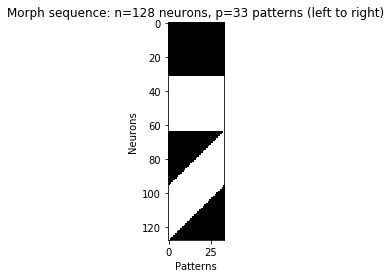

In [5]:
morph, p, n = init_morph()
plot_matrix(morph.T, fname='MorphSeq', title='Morph sequence: n={} neurons, p={} patterns (left to right)'.format(n,p), xlabel='Patterns', ylabel='Neurons')

## 2. Weighted Hebbian Learning rule

In [6]:
def Hebb(morph, weights=1.):
    """ Cells that fire together, wire together """ 
    J = (morph*np.sqrt(weights)).T.dot((morph*np.sqrt(weights)))/morph.shape[1] # Hebbian Rule
    return J # n*n synapse matrix

## 3. Dynamics

In [7]:
def hamming_dist(array1, array2):
    norm = int(np.shape(array1)[0]/2)
    return np.sum([1 for diff in np.abs(array2-array1) if diff!=0])/norm

def one_step(s_t, J):
    ''' Synchronous update (Parallel dynamics)'''
    return np.sign(J.dot(s_t))

def dynamic(s_0, J, n_iter_max=100):
    s_t = s_0
    for t in range(n_iter_max):
        s_ = one_step(s_t=s_t, J=J)
        if t==0:
            H = hamming_dist(s_0, s_)
        if np.sum(np.abs(s_-s_t))<1/J.shape[0]:
            #print('Converged in',t,'iterations:', s_)
            return s_, H
        else:
            s_t = s_

### 3.1. Standard Hopfield Model

In [8]:
def Hofield_Net(plot_J = False, plot_A = False):
    J = Hebb(morph)
    if plot_J: 
        plot_matrix(J, fname='Hopfield_Synapses', xlabel='i', ylabel='j',title='Synaptic Weights: J {}x{}'.format(J.shape[0], J.shape[1]), colorbar=True)
    attractors = np.zeros((p,n))
    for i, stimuli in enumerate(morph):
        attractors[i], H = dynamic(s_0=stimuli, J=J)
    p_ = np.unique(attractors, axis=0).shape[0]
    if plot_A: 
        plot_matrix(attractors.T, fname='Hopfield_MorphAttractors', xlabel='Morph sequence', ylabel='Attractor state', title='{} stimuli --> {} attractors (Standard Model)'.format(p,p_))
    return J

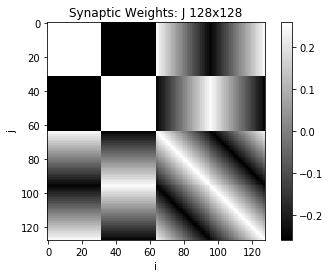

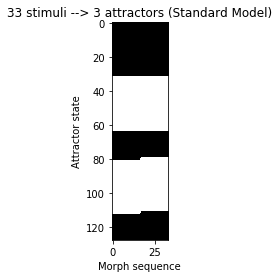

In [9]:
_ = Hofield_Net(plot_J=True, plot_A=True)

### 3.2. Novelty-facilitated synaptic plasticity

In [10]:
def normalize(w):
    return w.shape[0]*w/np.sum(w)

def init_weights(p, prior='uniform'):
    if prior=='skewed':
        w_ = np.expand_dims((np.arange(p)/(p-1)-0.5)**2, 1) # gradual bias toward source morph0 and target morph1
    elif prior=='biased':
        w_ = np.zeros(p)
        w_[0], w_[-1] = 1, 1
        w_ = np.expand_dims(w_, 1)
    else: # 'uniform'
        w_ = np.expand_dims(np.ones(p), 1) # uniform distribution
    w_ = normalize(w_)
    J_ = Hebb(morph, weights=w_)
    return w_, J_

def update_weights(w, i, H, eta=0.5):
    ''' Assymetric learning (Saliencies)'''
    w_ = np.copy(w)
    w_[i] = w_[i] + eta*H
    w_ = normalize(w_)
    J_ = Hebb(morph, weights=w_)
    return w_, J_

In [11]:
def memorize(protocol=0, prior='uniform', epoch=1000, plot_S = True, plot_J = True, plot_A = False):
    w, J = init_weights(p, prior=prior)

    weights = [w.flatten()]
    attractors = np.zeros((p,n))
    for _ in range(epoch):
        index = np.arange(p) # gradual protocol
        if protocol!=0: # mixed protocol
            np.random.shuffle(index)

        for i in index:
            attractors[i], H = dynamic(s_0=morph[i], J=J)
            w, J = update_weights(w=w, i=i, H=H)
        weights.append(w.flatten())

        if np.sum(np.abs(attractors-morph))==0:
            print('Protocol {}, with {} initialization, converged in {} iterations'.format(protocol, prior, _+1))
            break   

    if plot_S:
        plot_matrix(np.array(weights), fname='Saliency_Weights{}_{}'.format(protocol, prior), xlabel='Pattern', ylabel='Epoch', title='Saliency weights: {} patterns (converged in {} iterations)'.format(p, _+1), colorbar=True)
    if plot_J:
        plot_matrix(J, fname='Novelty_Synapses{}_{}'.format(protocol, prior), xlabel='i', ylabel='j', title='Synaptic Weights J: {}x{}'.format(J.shape[0], J.shape[1]), colorbar=True)
    if plot_A: 
        p_ = np.unique(attractors, axis=0).shape[0]
        plot_matrix(attractors.T, fname='Novelty_MorphAttractors', xlabel='Morph sequence', ylabel='Attractor state', title='{} stimuli --> {} attractors (Novelty Facilitated Model)'.format(p,p_))
    
    return w, J

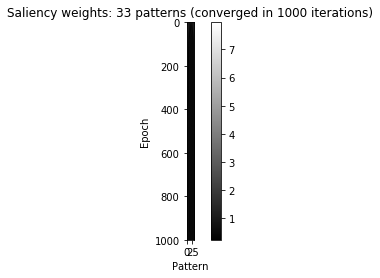

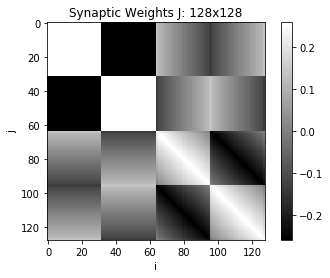

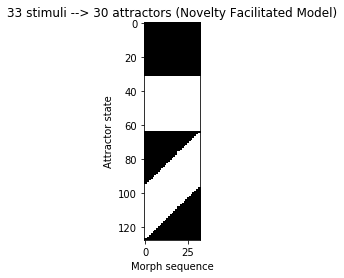

Protocol 0, with biased initialization, converged in 554 iterations


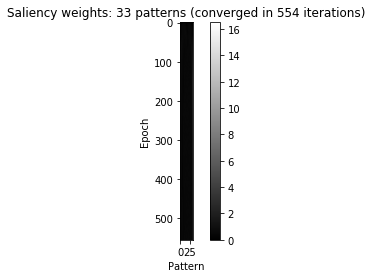

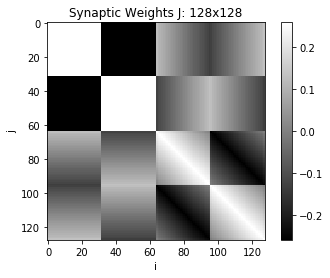

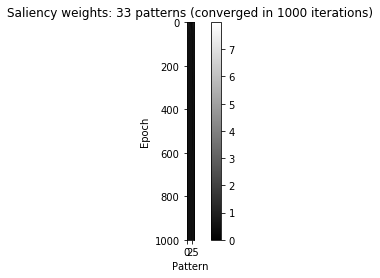

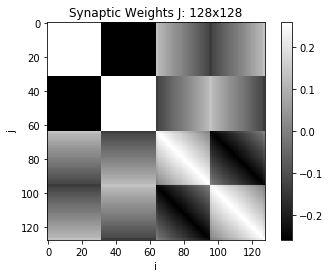

In [12]:
_,_ = memorize(protocol=0, prior='uniform', plot_S=True, plot_J=True, plot_A=True) # gradual, uniform init
_,_ = memorize(protocol=0, prior='biased') # gradual, biased init
_,_ = memorize(protocol=0, prior='skewed') # gradual, skewed init

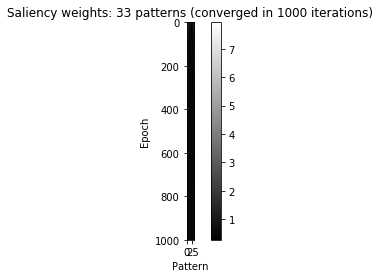

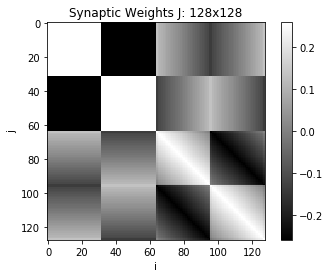

Protocol 1, with biased initialization, converged in 38 iterations


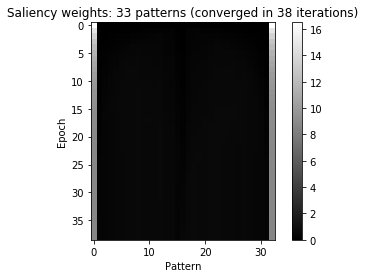

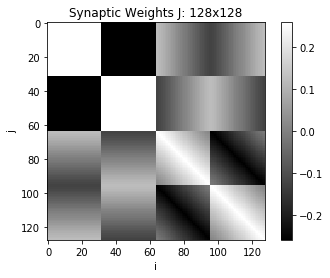

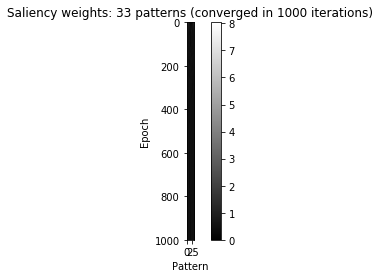

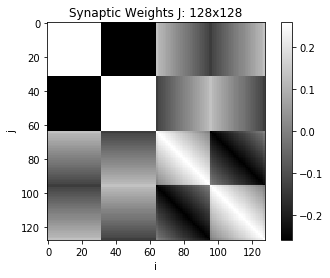

In [13]:
_,_ = memorize(protocol=1, prior='uniform') # mixed, uniform init
_,_ = memorize(protocol=1, prior='biased') # mixed, biased init
_,_ = memorize(protocol=1, prior='skewed') # mixed, skewed init

## 4. Energy and Stability analysis

### 4.1. Lyapunov function (energy)

In [14]:
def E(s,J):
    return -0.5*s.dot(J.dot(s))

### 4.2. Attractor Manifold & Stability

In [15]:
from sklearn.decomposition import PCA
colors={0: 'red', 1:'blue', 2:'grey', 3:'yellow', 4:'green', 5:'purple', 6:'pink', 7:'orange', 8:'beige',
        9: 'aqua'}
for i in range(10):
    colors[i+10]=colors[i]
    colors[i+20]=colors[i]
    colors[i+30]=colors[i]

In [16]:
def bassins_of_attract(J, name=''):
    stimuli, Es = [], []
    attractors = []
    
    # ideal stimulus = inprinted patterns
    for i, stimulus in enumerate(morph):
        stimuli.append(np.expand_dims(stimulus,0)) # stimulus
        Es.append(E(s=stimulus, J=J)) # energy
        attractor, H = dynamic(s_0=stimulus, J=J)
        attractors.append(np.expand_dims(attractor,0)) # attractor
        
    # noisy stimulus
    for switch in [+1,-1]:
        for j in range(int(n/2),n): # add noise to neuron j
            for i, stimulus in enumerate(morph):
                noisy_stimulus = np.copy(stimulus)
                if noisy_stimulus[j] != switch: # turn neuron on (over-complete pattern) or off (under-complete pattern)
                    noisy_stimulus[j] = switch
                    stimuli.append(np.expand_dims(noisy_stimulus,0)) # stimulus
                    Es.append(E(s=noisy_stimulus, J=J)) # energy
                    attractor, H = dynamic(s_0=noisy_stimulus, J=J)
                    attractors.append(np.expand_dims(attractor,0)) # attractor
                    
    stimuli = np.concatenate(stimuli, axis=0) # stimulus
    Es = np.array(Es) # energy
    unique_A, indices = np.unique(np.concatenate(attractors, axis=0), axis=0, return_inverse=True) # attractor
    
    # find fixed points id (stimuli, Es)
    attr_id = [] 
    for i,s in enumerate(stimuli):
        dist2_memories = np.array([hamming_dist(s,attr) for attr in unique_A])
        if 0. in dist2_memories:
            attr_id.append(i)
    Ea = Es[np.array(attr_id)] # attractor energy

    # Plot Input
    plot_matrix(stimuli.T, fname='Noisy_Stimuli', ylabel='Neurons', xlabel='Stimuli', title='{} noisy stimuli encoded with {} neurons (left to right)'.format(stimuli.shape[0], stimuli.shape[1]))
    
    # Plot Output
    plot_matrix(np.concatenate(attractors, axis=0).T, fname= name+'_Recall', ylabel='Attractor State', xlabel='Stimuli', title='Retrieved memories (left to right)')
    
    # Plot Bassins of attraction (Stimuli + Energy + Cluster)
    plt.figure(1)
    my_pca = PCA(n_components=1)
    unique_A = my_pca.fit_transform(unique_A)
    stimuli = my_pca.transform(stimuli)
    for i, attr in enumerate(unique_A):
        plt.plot([attr[0]], [Ea[i]], marker='o', color=colors[i], markersize=11) # attractor pattern
        basin_attr = stimuli[np.where(indices==i)[0]] # stimuli in attractor bassin
        plt.scatter(basin_attr[:,0], Es[np.where(indices==i)[0]], marker='+', color=colors[i])
    plt.title('{} bassins of attraction (PCA(k=1) on attractor states)'.format(unique_A.shape[0]))
    plt.xlabel('1st PCA component of stimuli neural code')
    plt.ylabel('Energy')
    plt.savefig('img/{}/{}_PCA'.format(n4,name))
    plt.show()
    
    # Plot Energy levels (attractors ie local minima in green)
    plt.figure(1)
    plt.bar(np.arange(morph.shape[0]), Es[:morph.shape[0]], color='red', label='stimuli', align='edge')
    plt.bar(attr_id, Ea, color='green', label='fixed points', align='edge')
    plt.xlim(0., morph.shape[0])
    plt.ylim(min(Es)-1,max(Es)+1)
    plt.ylabel('Energy')
    plt.xlabel('Patterns')
    plt.title('Energy distribution. Green Patterns = Fixed points (local minima of E)')
    plt.savefig('img/{}/{}_MorphEnergy'.format(n4,name))
    plt.show()
    

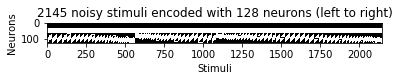

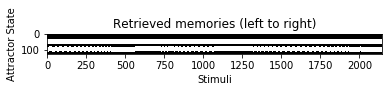

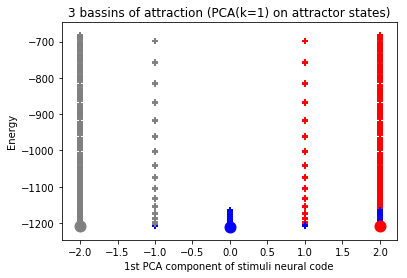

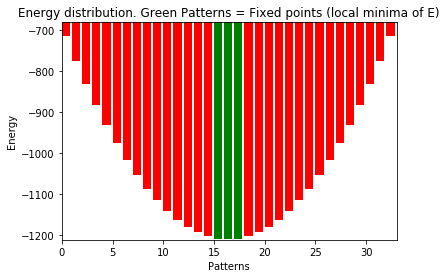

Protocol 0, with biased initialization, converged in 554 iterations


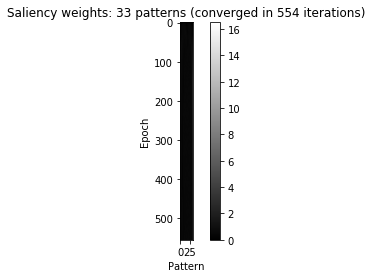

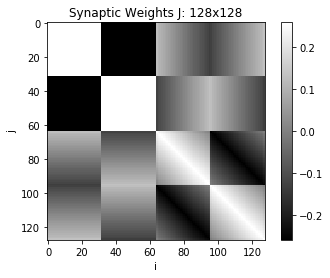

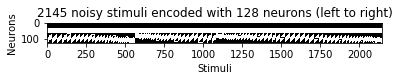

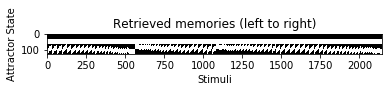

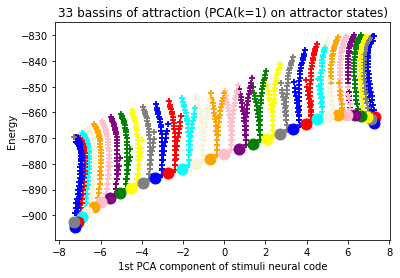

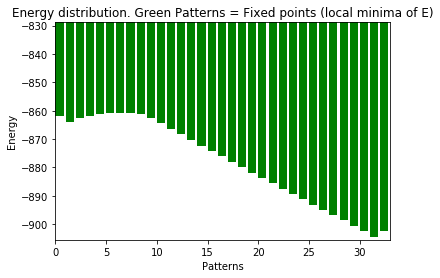

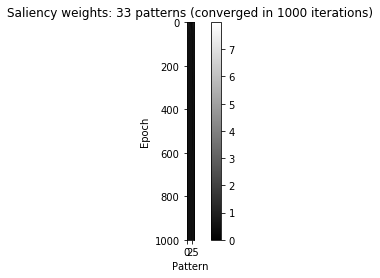

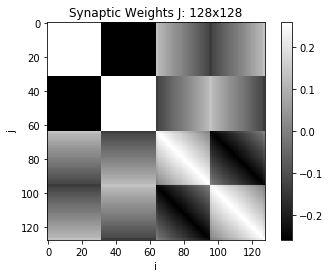

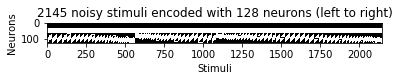

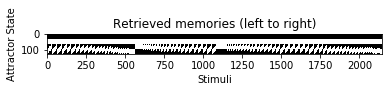

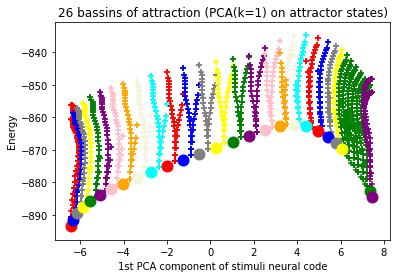

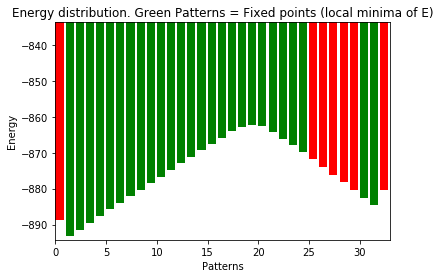

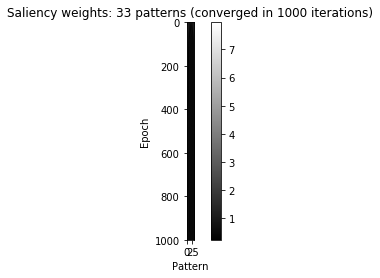

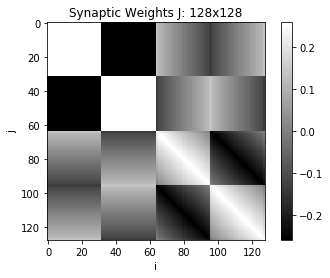

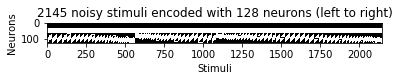

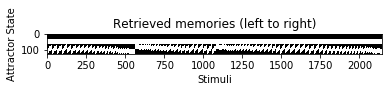

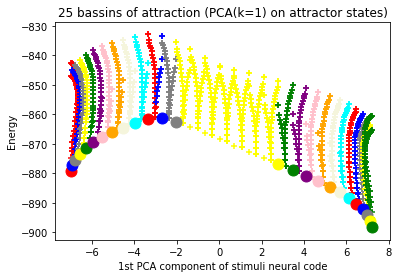

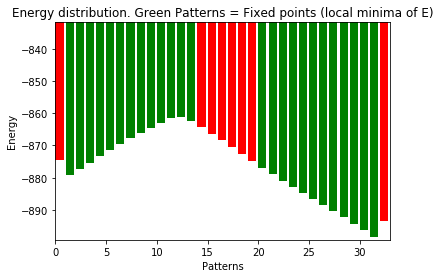

Protocol 1, with biased initialization, converged in 27 iterations


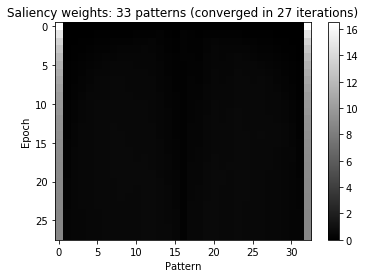

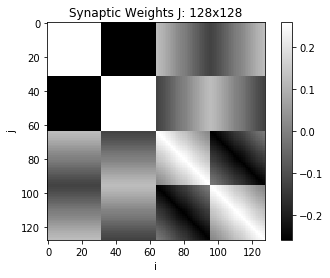

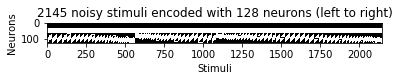

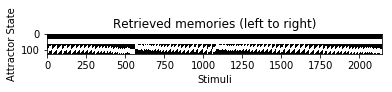

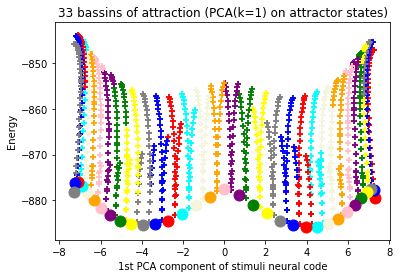

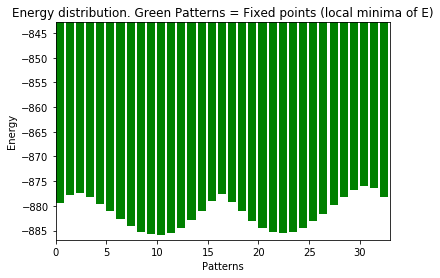

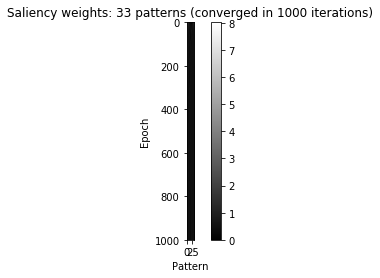

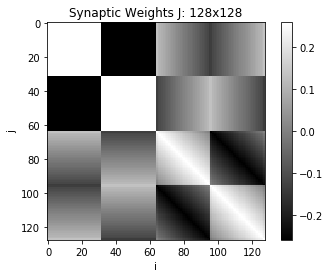

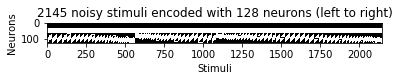

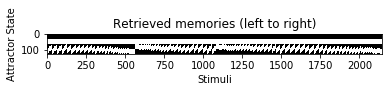

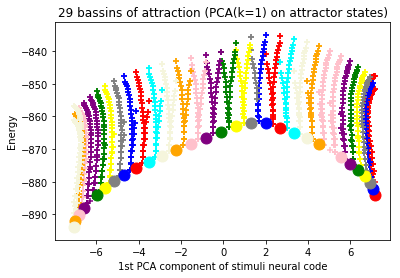

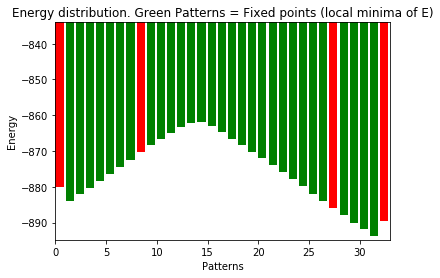

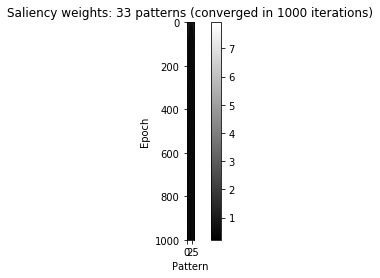

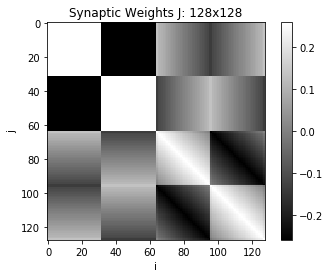

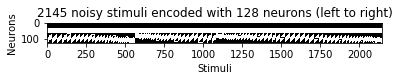

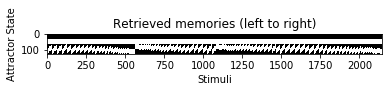

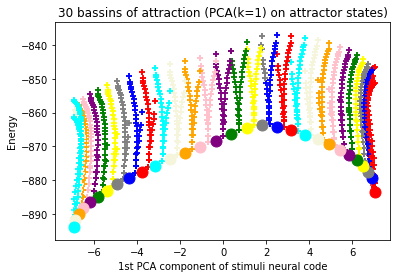

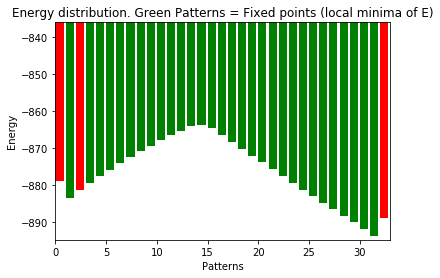

In [17]:
# Standard Hopfield Network
J = Hofield_Net() 
bassins_of_attract(J, name='Hopfield')
# Novelty dynamics
for protocol_ in [0,1]: 
    for prior_ in ['biased','skewed','uniform']:
        try:
            w,J = memorize(protocol=protocol_, prior=prior_)
            bassins_of_attract(J, name='Novelty{}_{}'.format(protocol_, prior_))
        except:
            pass